!pip install --upgrade pip
!pip install numpy --upgrade --user
!pip install pandas --upgrade --user
!pip install scikit-learn --upgrade --user

In [2]:
import warnings
warnings.simplefilter(action='ignore',category=UserWarning)
warnings.simplefilter(action='ignore',category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [4]:
train = pd.read_csv("https://dim-mlpython.s3.amazonaws.com/CreditRiskModeling/train.csv", low_memory=False)
test = pd.read_csv("https://dim-mlpython.s3.amazonaws.com/CreditRiskModeling/test.csv", low_memory=False)

In [30]:
cleancolumn = []
for i in range(len(train.columns)):
    cleancolumn.append(train.columns[i].replace(' ','_').lower())
train.columns = cleancolumn

In [31]:
train.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,a3fdf1db-e991-4293-976c-7d35564c0aec,74561f96-304a-492d-bc19-a6107d2afee9,Charged Off,10120,Long Term,6920.000,10+ years,Rent,47564.000,Debt Consolidation,990.92,21.800,28.000,10,0,3840,7694,0.000,0.000
1,c3f8006d-d1ef-4a94-ba55-c48034974205,b8e70101-dd49-4a39-84a6-5f92b390684c,Fully Paid,7144,Short Term,721.000,2 years,Home Mortgage,40820.000,Debt Consolidation,574.88,10.700,nan,6,0,13269,22565,0.000,0.000
2,076b722f-3658-47a8-a7f1-5179a9b45ade,0a28e046-9239-4ee0-8770-68a2f72bf2a0,Fully Paid,10100,Short Term,726.000,7 years,Own Home,54540.000,Debt Consolidation,577.22,37.300,nan,6,0,5373,8667,0.000,0.000
3,c2d68e37-572b-4a3b-afaa-b55a679c7d67,dc755ef2-1773-4d3b-8b6b-668bbae290c5,Fully Paid,30362,Long Term,708.000,1 year,Home Mortgage,63450.000,Debt Consolidation,1110.37,12.500,52.000,14,0,38329,57207,0.000,0.000
4,c02558d1-58cb-4b36-9569-ae55baeb328a,f0804ea2-249b-4e6c-ab2a-1554a7ff6a5b,Fully Paid,3571,Short Term,700.000,5 years,Home Mortgage,41370.000,Debt Consolidation,875.67,13.100,6.000,4,0,384,985,0.000,0.000


In [32]:
print(train.shape)
train.describe()

(77823, 19)


,current_loan_amount,credit_score,annual_income,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens
count,77823.000,62908.000,62908.000,77823.000,36414.000,77823.000,77823.000,77823.000,77675.000,77818.000
mean,11537410.504,1070.662,72473.466,18.202,34.854,11.117,0.169,15529.053,0.119,0.029
std,31927864.472,1464.730,58417.419,7.030,21.889,5.013,0.483,20322.248,0.353,0.254
min,885.000,585.000,4268.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000
25%,8149.500,705.000,44679.750,13.500,16.000,8.000,0.000,5879.000,0.000,0.000
50%,14213.000,724.000,61770.000,16.900,32.000,10.000,0.000,11008.000,0.000,0.000
75%,23861.500,741.000,86952.250,21.700,51.000,14.000,0.000,19427.500,0.000,0.000
max,99999999.000,7510.000,8713547.000,62.500,176.000,76.000,12.000,1730472.000,7.000,11.000


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77823 entries, 0 to 77822
Data columns (total 19 columns):
loan_id                         77823 non-null object
customer_id                     77823 non-null object
loan_status                     77823 non-null object
current_loan_amount             77823 non-null int64
term                            77823 non-null object
credit_score                    62908 non-null float64
years_in_current_job            74500 non-null object
home_ownership                  77823 non-null object
annual_income                   62908 non-null float64
purpose                         77823 non-null object
monthly_debt                    77823 non-null object
years_of_credit_history         77823 non-null float64
months_since_last_delinquent    36414 non-null float64
number_of_open_accounts         77823 non-null int64
number_of_credit_problems       77823 non-null int64
current_credit_balance          77823 non-null int64
maximum_open_credit        

In [34]:
unique_loanid=train['loan_id'].unique().tolist()
print("Total samples in data:",str(train.shape[0]))
print("Total unique samples in data:",str(len(unique_loanid)))
print("Duplicate samples in data",str(train.shape[0]-len(unique_loanid)))

Total samples in data: 77823
Total unique samples in data: 62237
Duplicate samples in data 15586


In [35]:
train = train.drop_duplicates()
print("Total samples in data:",str(train.shape[0]))
print("Total unique samples in data:",str(len(unique_loanid)))
print("Duplicate samples in data",str(train.shape[0]-len(unique_loanid)))

Total samples in data: 69076
Total unique samples in data: 62237
Duplicate samples in data 6839


In [36]:
dup_loanid = train[train.duplicated(['loan_id'],keep=False)]
print(dup_loanid.shape)
dup_loanid.describe()

(13678, 19)


,current_loan_amount,credit_score,annual_income,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens
count,13678.000,10003.000,10003.000,13678.000,7238.000,13678.000,13678.000,13678.000,13658.000,13676.000
mean,22734326.610,699.678,72329.080,17.805,34.127,11.254,0.207,15804.026,0.140,0.039
std,41899176.187,24.989,46577.155,7.000,21.766,5.186,0.533,18911.803,0.371,0.299
min,978.000,587.000,9756.000,3.700,0.000,1.000,0.000,0.000,0.000,0.000
25%,9793.000,690.000,44928.000,13.000,15.000,8.000,0.000,5755.250,0.000,0.000
50%,17797.500,708.000,61362.000,16.700,31.000,10.000,0.000,10962.000,0.000,0.000
75%,35046.500,718.000,87014.500,21.400,50.000,14.000,0.000,19879.750,0.000,0.000
max,99999999.000,725.000,934705.000,59.500,91.000,47.000,9.000,291341.000,4.000,9.000


In [37]:
sorted_df = dup_loanid.sort_values(['current_loan_amount','credit_score'],ascending=True,na_position='last')
sorted_df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
58916,07f5fb21-82d8-4cd8-98eb-cef89b460348,90dcf223-324c-4579-9062-9e275d1a9ec0,Fully Paid,978,Short Term,718.000,NaN,Home Mortgage,74313.000,major_purchase,1226.16,34.800,10.000,10,0,16547,17603,0.000,0.000
5957,2bc65e92-50b3-453f-88f4-101aa3f7c631,85e53503-06fe-45f1-8c6e-48618b924167,Fully Paid,979,Short Term,711.000,10+ years,Rent,29367.000,Debt Consolidation,702.36,46.700,nan,11,0,14133,15181,0.000,0.000
62240,2bc65e92-50b3-453f-88f4-101aa3f7c631,85e53503-06fe-45f1-8c6e-48618b924167,Fully Paid,979,Short Term,nan,10+ years,Rent,nan,Debt Consolidation,702.36,46.700,nan,11,0,14133,15181,0.000,0.000
33249,38af5e3a-9d54-456a-b335-21e172018517,5c92cda7-7386-47b4-b3d6-56c0e278e56f,Fully Paid,982,Short Term,697.000,5 years,Home Mortgage,29472.000,Debt Consolidation,44.21,11.500,nan,3,0,2021,8456,0.000,0.000
56983,ae401455-a534-4d31-bafa-3b1e0474a35b,c8c64614-1c34-49d9-a608-64dc942cf447,Fully Paid,983,Short Term,698.000,< 1 year,Rent,37343.000,Debt Consolidation,886.89,13.000,nan,11,0,17472,19074,0.000,0.000


In [38]:
correct_df = sorted_df.drop_duplicates(['loan_id'],keep='first')
print(correct_df.shape)
correct_df.head()

(6839, 19)


,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
58916,07f5fb21-82d8-4cd8-98eb-cef89b460348,90dcf223-324c-4579-9062-9e275d1a9ec0,Fully Paid,978,Short Term,718.000,NaN,Home Mortgage,74313.000,major_purchase,1226.16,34.800,10.000,10,0,16547,17603,0.000,0.000
5957,2bc65e92-50b3-453f-88f4-101aa3f7c631,85e53503-06fe-45f1-8c6e-48618b924167,Fully Paid,979,Short Term,711.000,10+ years,Rent,29367.000,Debt Consolidation,702.36,46.700,nan,11,0,14133,15181,0.000,0.000
33249,38af5e3a-9d54-456a-b335-21e172018517,5c92cda7-7386-47b4-b3d6-56c0e278e56f,Fully Paid,982,Short Term,697.000,5 years,Home Mortgage,29472.000,Debt Consolidation,44.21,11.500,nan,3,0,2021,8456,0.000,0.000
56983,ae401455-a534-4d31-bafa-3b1e0474a35b,c8c64614-1c34-49d9-a608-64dc942cf447,Fully Paid,983,Short Term,698.000,< 1 year,Rent,37343.000,Debt Consolidation,886.89,13.000,nan,11,0,17472,19074,0.000,0.000
47807,df1680ed-de74-4ec4-ab3c-cdacfd2a911e,b44395a3-4f94-41ff-ad65-8f1d8b06919d,Fully Paid,983,Short Term,714.000,5 years,Home Mortgage,44959.000,other,338.32,11.400,nan,9,0,8182,9245,0.000,0.000


In [39]:
correct_df[correct_df['current_loan_amount']==99999999]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [40]:
correct_df[correct_df['credit_score'].isnull()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [41]:
train.drop_duplicates(['loan_id'],keep=False,inplace=True)

In [42]:
train.shape

(55398, 19)

In [43]:
train = train.append(correct_df,ignore_index=True)
print(train.shape)
train.describe()

(62237, 19)


,current_loan_amount,credit_score,annual_income,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens
count,62237.000,50997.000,50997.000,62237.000,28203.000,62237.000,62237.000,62237.000,62112.000,62233.000
mean,9429888.029,1157.211,72470.303,18.316,35.066,11.105,0.162,15480.221,0.114,0.028
std,29202977.662,1614.569,60939.354,7.063,21.933,4.986,0.472,20276.316,0.345,0.249
min,885.000,585.000,4268.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000
25%,8060.000,711.000,44681.000,13.500,16.000,8.000,0.000,5925.000,0.000,0.000
50%,13425.000,731.000,61708.000,17.000,32.000,10.000,0.000,11014.000,0.000,0.000
75%,21628.000,743.000,86912.000,21.800,51.000,14.000,0.000,19365.000,0.000,0.000
max,99999999.000,7510.000,8713547.000,62.500,176.000,76.000,12.000,1730472.000,7.000,11.000


In [44]:
train['years_in_current_job'].unique()

array(['10+ years', '2 years', '7 years', '5 years', '< 1 year',
       '4 years', '8 years', '1 year', '3 years', nan, '6 years',
       '9 years'], dtype=object)

In [45]:
train['years_in_current_job']=[0 if str(x)=='< 1 year' else x if str(x)=='nan' else int(re.findall(r'\d+', str(x))[0]) for x in train['years_in_current_job']]
train['years_in_current_job'].unique()

array([10.,  2.,  7.,  5.,  0.,  4.,  8.,  1.,  3., nan,  6.,  9.])

In [46]:
train['credit_score'].head(10)

0   6920.000
1    721.000
2    726.000
3    707.000
4    700.000
5    733.000
6    694.000
7    724.000
8   6950.000
9        nan
Name: credit_score, dtype: float64

In [47]:
def credit_range(x):
    if x>800:
        return int(x/10)
    elif str(x) == 'nan':
        return x
    else:
        return int(x)

In [48]:
train['credit_score'] = train['credit_score'].map(credit_range)
train['credit_score'].head(10)

0   692.000
1   721.000
2   726.000
3   707.000
4   700.000
5   733.000
6   694.000
7   724.000
8   695.000
9       nan
Name: credit_score, dtype: float64

In [49]:
print(train.shape)
train[train['maximum_open_credit']=='#VALUE!']

(62237, 19)


,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
35792,b798f46b-e27b-4823-af83-294b1ffc3490,f61890c5-e264-4b0f-a047-9cfa03b9d182,Charged Off,1470,Short Term,nan,2.000,Rent,nan,Debt Consolidation,506.34,15.300,26.000,3,0,0,#VALUE!,0.000,0.000


In [50]:
train=train[train['maximum_open_credit']!='#VALUE!']
train['maximum_open_credit']= pd.to_numeric(train['maximum_open_credit'])
train.shape

(62236, 19)

In [51]:
train['monthly_debt']=train['monthly_debt'].str.strip('$')
train['monthly_debt']=pd.to_numeric(train['monthly_debt'])
train['monthly_debt'].describe()

count   62236.000
mean      963.653
std       642.180
min         0.000
25%       532.188
50%       842.560
75%      1250.362
max     22939.120
Name: monthly_debt, dtype: float64

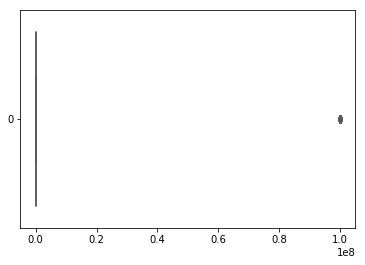

In [52]:
ax = sns.boxplot(data=train['current_loan_amount'],orient='h',palette="Set2")

In [53]:
train['current_loan_amount'] =[np.nan if int(x) == 99999999 else x for x in train['current_loan_amount']]

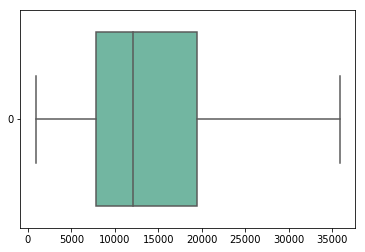

In [54]:
ax = sns.boxplot(data=train['current_loan_amount'],orient='h',palette="Set2")

In [55]:
train.describe()

,current_loan_amount,credit_score,years_in_current_job,annual_income,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
count,56375.000,50997.000,59559.000,50997.000,62236.000,62236.000,28202.000,62236.000,62236.000,62236.000,62236.000,62111.000,62232.000
mean,13976.863,720.100,5.880,72470.303,963.653,18.316,35.066,11.105,0.162,15480.470,35785.109,0.114,0.028
std,8296.618,27.891,3.627,60939.354,642.180,7.063,21.934,4.986,0.472,20276.384,372633.539,0.345,0.249
min,885.000,585.000,0.000,4268.000,0.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7800.000,708.000,3.000,44681.000,532.188,13.500,16.000,8.000,0.000,5925.750,12796.000,0.000,0.000
50%,12060.000,728.000,6.000,61708.000,842.560,17.000,32.000,10.000,0.000,11014.000,21813.500,0.000,0.000
75%,19478.000,741.000,10.000,86912.000,1250.362,21.800,51.000,14.000,0.000,19365.250,36476.000,0.000,0.000
max,35875.000,751.000,10.000,8713547.000,22939.120,62.500,176.000,76.000,12.000,1730472.000,69988086.000,7.000,11.000


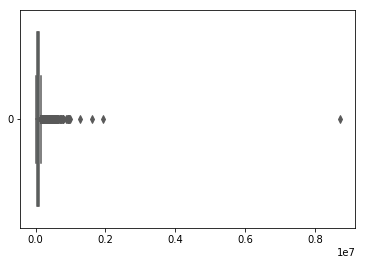

In [56]:
ax = sns.boxplot(data=train['annual_income'],orient='h',palette="Set2")

In [57]:
train[train['annual_income']==8713547.000]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
1574,6dfd2f9c-b796-4cb3-8f71-04d6ae8a8f92,ceee183a-9b02-4b82-ae53-14ccd5f785fd,Charged Off,8006.000,Short Term,725.000,10.000,Home Mortgage,8713547.000,Debt Consolidation,798.740,16.000,nan,11,0,16462,30429,0.000,0.000


In [59]:
train = train[train['annual_income']!=8713547.000]
train.shape

(62235, 19)

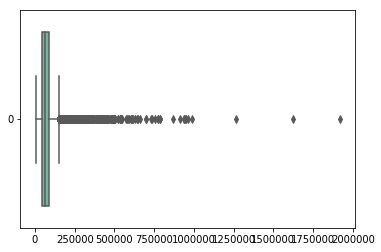

In [60]:
ax = sns.boxplot(data=train['annual_income'],orient='h',palette="Set2")

In [61]:
train[train['annual_income']>1200000]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
3686,d728b670-7248-4c64-b99e-251d9e7b88a2,a0222c05-0157-4791-b2b9-c74d51774d16,Charged Off,34430.000,Long Term,739.000,0.000,Home Mortgage,1623105.000,Debt Consolidation,2637.550,14.700,17.000,15,0,26265,69668,0.000,0.000
11660,cbd2df62-ea45-4ae0-bbeb-1681d5655221,97b34fe1-09e4-4c27-b8cc-ec335ec29891,Charged Off,15928.000,Long Term,733.000,2.000,Home Mortgage,1262125.000,Debt Consolidation,22939.120,19.200,nan,10,0,48726,58565,0.000,0.000
46615,076e5ce5-cc5a-4c3e-8e11-91c31a4fa00e,ecc52a5d-a428-455c-9ae6-332cafac55b2,Fully Paid,28291.000,Short Term,747.000,6.000,Own Home,1919760.000,Debt Consolidation,335.960,11.200,nan,7,0,13889,25768,0.000,0.000


In [63]:
train = train.drop([3686,11660,46615])
train.shape

(62232, 19)

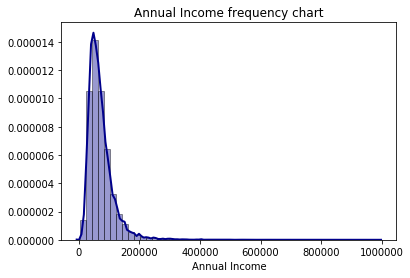

In [64]:
ax = sns.distplot(train['annual_income'].dropna(), hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Annual Income') 
plt.title('Annual Income frequency chart'); 
plt.show()

In [65]:
train.describe()

,current_loan_amount,credit_score,years_in_current_job,annual_income,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
count,56371.000,50993.000,59555.000,50993.000,62232.000,62232.000,28201.000,62232.000,62232.000,62232.000,62232.000,62107.000,62228.000
mean,13976.318,720.099,5.880,72210.882,963.286,18.316,35.067,11.105,0.162,15479.772,35784.446,0.114,0.028
std,8296.204,27.891,3.627,45909.542,636.089,7.064,21.934,4.986,0.472,20276.550,372645.476,0.345,0.249
min,885.000,585.000,0.000,4268.000,0.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7800.000,708.000,3.000,44681.000,532.188,13.500,16.000,8.000,0.000,5925.000,12795.750,0.000,0.000
50%,12060.000,728.000,6.000,61696.000,842.560,17.000,32.000,10.000,0.000,11013.500,21812.000,0.000,0.000
75%,19478.000,741.000,10.000,86887.000,1250.322,21.800,51.000,14.000,0.000,19364.250,36475.250,0.000,0.000
max,35875.000,751.000,10.000,986523.000,12055.680,62.500,176.000,76.000,12.000,1730472.000,69988086.000,7.000,11.000


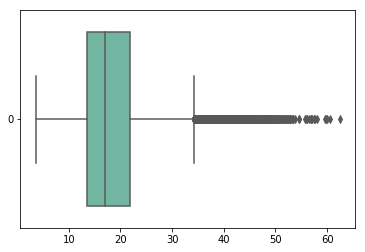

In [67]:
ax = sns.boxplot(data=train['years_of_credit_history'],orient='h',palette="Set2")

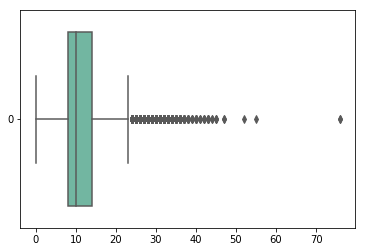

In [69]:
ax = sns.boxplot(data=train['number_of_open_accounts'],orient='h',palette="Set2")

In [70]:
train[train['years_of_credit_history']>58]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
1908,cd5ca817-ff39-41e1-8dcd-3a86346c4631,33dd7f5c-92fa-4dcf-b798-6565b8281f0d,Fully Paid,14829.000,Short Term,741.000,7.000,Home Mortgage,86008.000,Business Loan,860.800,59.900,nan,9,1,4558,9596,1.000,0.000
32096,433a4adf-886b-4df7-998a-a0e171fb98bc,7e068df8-61ed-4418-9e6f-9d7610f3238f,Fully Paid,14802.000,Short Term,nan,nan,Home Mortgage,nan,Debt Consolidation,821.020,62.500,24.000,8,0,7007,23593,0.000,0.000
45779,0ca8800a-36f0-48b3-9564-2cce86190862,b6d390e3-8cb6-44b7-981a-ce00be0ca85f,Charged Off,21197.000,Short Term,nan,10.000,Home Mortgage,nan,Debt Consolidation,1574.660,60.500,48.000,11,1,7928,19575,1.000,0.000
49017,133375dc-a8ef-481a-854e-2958fc7ca9f6,a23f7854-accc-48c6-8634-d9277f92c10b,Charged Off,20190.000,Short Term,710.000,10.000,Home Mortgage,46290.000,Home Improvements,690.490,59.700,nan,7,0,2865,7091,0.000,0.000
61832,7e687480-14cb-416e-bc82-faea0ccf2a71,0c401d4d-523a-4eb5-97b0-f5677fd34ade,Fully Paid,34192.000,Long Term,676.000,10.000,Home Mortgage,126509.000,Debt Consolidation,3478.990,59.500,nan,15,0,59003,71259,0.000,0.000


In [71]:
train = train.drop([1908,32096,45779,49017,61832])

In [72]:
train[train['number_of_open_accounts']>50]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
26502,7d000d90-1538-4d4d-b7c2-15724be2025e,080f449b-c0b7-4226-8a51-cdcc7e68954f,Fully Paid,6082.000,Short Term,742.000,10.000,Home Mortgage,71973.000,Debt Consolidation,422.840,18.700,nan,52,0,7234,164404,0.000,0.000
26637,4f8a7824-b9bd-4b8c-b2a1-6b7b196d2c0f,67a534d6-7038-4e0b-8d42-8aab6d220701,Fully Paid,28185.000,Long Term,744.000,2.000,Home Mortgage,201320.000,Debt Consolidation,4429.040,15.600,nan,55,0,34159,185646,0.000,0.000
27936,08dab131-9db3-4184-a32a-e12e48fd5d6c,907c2a89-76f8-4089-9a47-d410bb885339,Charged Off,18755.000,Long Term,670.000,7.000,Rent,46912.000,Debt Consolidation,1032.060,27.400,nan,76,0,22111,28131,0.000,0.000
39254,f4e0a453-a5ec-4011-9513-9d203ffe8e3c,3e62a9e2-a61b-472d-8e56-234e30061580,Charged Off,20426.000,Short Term,708.000,5.000,Home Mortgage,122556.000,Debt Consolidation,2195.800,15.700,nan,76,0,40606,121575,0.000,0.000


In [73]:
train = train.drop([26502,26637,27936,39254])

In [74]:
#Capping the outliers
IQR = train['number_of_open_accounts'].quantile(0.75) - train['number_of_open_accounts'].quantile(0.25)
upper_limit = train['number_of_open_accounts'].quantile(0.75) + (IQR * 1.5)
print("Upper Limit:", upper_limit)

Upper Limit: 23.0


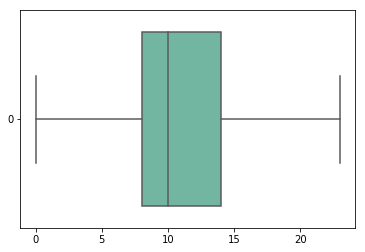

In [75]:
train['number_of_open_accounts'] = [23.0 if ( x>23.0 and x!=np.nan) else x for x in train['number_of_open_accounts']]
ax = sns.boxplot(data=train['number_of_open_accounts'], orient="h", palette="Set2")

In [80]:
train.isnull().sum()

loan_id                             0
customer_id                         0
loan_status                         0
current_loan_amount              5847
term                                0
credit_score                    11216
years_in_current_job             2676
home_ownership                      0
annual_income                   11216
purpose                             0
monthly_debt                        0
years_of_credit_history             0
months_since_last_delinquent    34024
number_of_open_accounts             0
number_of_credit_problems           0
current_credit_balance              0
maximum_open_credit                 0
bankruptcies                        0
tax_liens                           0
dtype: int64

In [79]:
train = train.dropna(subset=['bankruptcies','tax_liens'])


In [81]:
train["months_since_last_delinquent"].fillna(0, inplace = True)
print(train.shape)
train.isnull().sum()

(62098, 19)


loan_id                             0
customer_id                         0
loan_status                         0
current_loan_amount              5847
term                                0
credit_score                    11216
years_in_current_job             2676
home_ownership                      0
annual_income                   11216
purpose                             0
monthly_debt                        0
years_of_credit_history             0
months_since_last_delinquent        0
number_of_open_accounts             0
number_of_credit_problems           0
current_credit_balance              0
maximum_open_credit                 0
bankruptcies                        0
tax_liens                           0
dtype: int64

In [82]:
train.reset_index(drop=True, inplace=True)
my_imputer = IterativeImputer()
#For this we need only numerical variables so filtering this
train_numerical = train._get_numeric_data()
train_numerical_columns = train_numerical.columns 
print(train_numerical.shape)
train_numerical.isnull().sum()

(62098, 13)


current_loan_amount              5847
credit_score                    11216
years_in_current_job             2676
annual_income                   11216
monthly_debt                        0
years_of_credit_history             0
months_since_last_delinquent        0
number_of_open_accounts             0
number_of_credit_problems           0
current_credit_balance              0
maximum_open_credit                 0
bankruptcies                        0
tax_liens                           0
dtype: int64

In [83]:
train_imputed = my_imputer.fit_transform(train_numerical)
train_imputed = pd.DataFrame(train_imputed,columns=train_numerical_columns)
train_imputed.isnull().sum()

current_loan_amount             0
credit_score                    0
years_in_current_job            0
annual_income                   0
monthly_debt                    0
years_of_credit_history         0
months_since_last_delinquent    0
number_of_open_accounts         0
number_of_credit_problems       0
current_credit_balance          0
maximum_open_credit             0
bankruptcies                    0
tax_liens                       0
dtype: int64

In [84]:
train_imputed.describe()

,current_loan_amount,credit_score,years_in_current_job,annual_income,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
count,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000,62098.000
mean,13856.079,720.194,5.902,72029.815,963.898,18.308,15.896,11.008,0.162,15483.161,35747.365,0.114,0.028
std,8031.639,25.476,3.556,43189.244,635.785,7.055,22.866,4.647,0.473,20273.467,372989.003,0.345,0.249
min,975.000,585.000,0.000,4268.000,0.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7973.000,711.000,3.000,45869.684,532.758,13.500,0.000,8.000,0.000,5935.250,12798.250,0.000,0.000
50%,12036.000,725.000,6.000,63011.000,843.110,17.000,0.000,10.000,0.000,11021.000,21812.000,0.000,0.000
75%,18418.000,739.000,10.000,86424.663,1251.043,21.800,28.000,14.000,0.000,19373.750,36466.000,0.000,0.000
max,91948.471,764.719,10.381,986523.000,12055.680,58.000,176.000,23.000,12.000,1730472.000,69988086.000,7.000,11.000


In [85]:
train_imputed.shape

(62098, 13)

In [ ]:
train[''] = 